# Optimizing Sample Locations

**Problem:** Place sensors to maximize response at a target frequency.

Because nufftax is differentiable w.r.t. positions, we can use gradient-based optimization to learn optimal sensor placement.

## Setup

First, install nufftax if running on Colab:

In [ ]:
# Uncomment the following lines to install nufftax on Colab
# !pip install uv
# !uv pip install nufftax --system

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from nufftax import nufft1d1
import matplotlib.pyplot as plt

## Mathematical Background

The NUFFT response at frequency $k$ is:

$$f_k = \sum_{j=1}^{n} e^{i k x_j}$$

For constructive interference at frequency $k$, sensors should be spaced at $2\pi/k$.

**Key insight:** The theoretical maximum response is $n$ (all sensors in phase). We can learn this optimal spacing via gradient descent.

## Define Optimization Objective

In [3]:
n_sensors = 10
n_modes = 64
target_freq = 15  # Target frequency index

c = jnp.ones(n_sensors, dtype=jnp.complex64)

def get_spectrum(x):
    return jnp.abs(nufft1d1(x, c, n_modes=n_modes, eps=1e-6))

def objective(x):
    """Maximize fraction of energy at target frequency."""
    spectrum = get_spectrum(x)
    idx_pos = n_modes // 2 + target_freq
    idx_neg = n_modes // 2 - target_freq
    target_power = spectrum[idx_pos] + spectrum[idx_neg]
    return target_power / (jnp.sum(spectrum) + 1e-6)

## Run Optimization

In [4]:
# Initial random positions
key = jax.random.PRNGKey(42)
x_init = jax.random.uniform(key, (n_sensors,), minval=-jnp.pi*0.9, maxval=jnp.pi*0.9)
x = x_init.copy()

# Store initial spectrum
spectrum_init = get_spectrum(x_init)
print(f"Initial response at k={target_freq}: {spectrum_init[n_modes//2 + target_freq]:.2f}")

# Optimize with momentum
grad_fn = jax.grad(objective)
velocity = jnp.zeros_like(x)
lr, momentum = 0.1, 0.8

history = []
for step in range(300):
    velocity = momentum * velocity + lr * grad_fn(x)
    x = x + velocity
    x = jnp.clip(x, -jnp.pi*0.95, jnp.pi*0.95)
    history.append(float(objective(x)))

# Final spectrum
spectrum_final = get_spectrum(x)
print(f"Optimized response at k={target_freq}: {spectrum_final[n_modes//2 + target_freq]:.2f}")
print(f"Theoretical maximum: {n_sensors}")

Initial response at k=15: 1.74


Optimized response at k=15: 8.37
Theoretical maximum: 10


## Compare with Theoretical Optimal

In [5]:
# Theoretical optimal: spacing = 2*pi/k
spacing = 2 * jnp.pi / target_freq
x_theory = jnp.arange(n_sensors) * spacing - (n_sensors-1)/2 * spacing

spectrum_theory = get_spectrum(x_theory)

print(f"\nComparison:")
print(f"  Initial response:     {spectrum_init[n_modes//2 + target_freq]:.2f}")
print(f"  Optimized response:   {spectrum_final[n_modes//2 + target_freq]:.2f}")
print(f"  Theoretical response: {spectrum_theory[n_modes//2 + target_freq]:.2f}")
print(f"  Maximum possible:     {n_sensors}")


Comparison:
  Initial response:     1.74
  Optimized response:   8.37
  Theoretical response: 10.00
  Maximum possible:     10


## Visualization

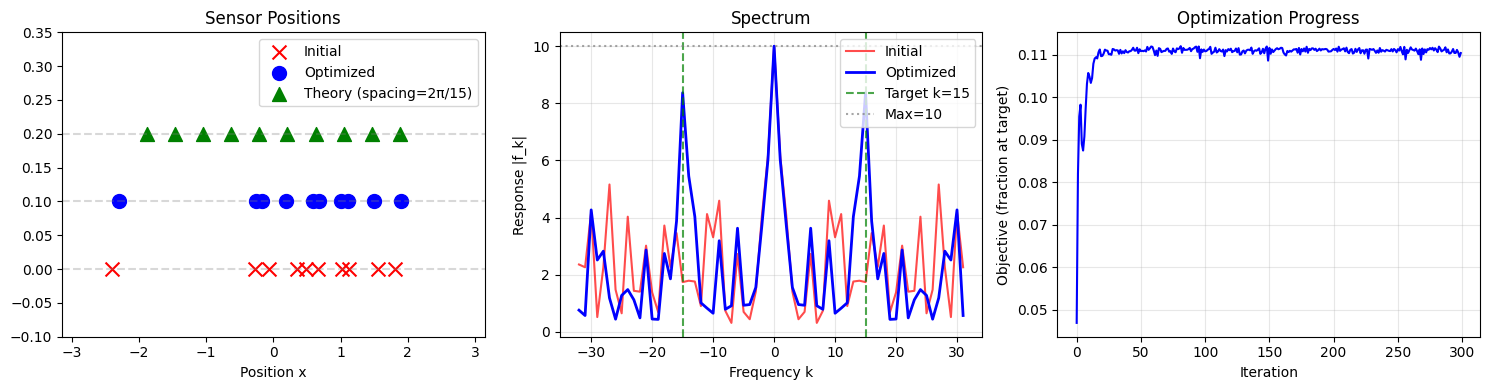

In [6]:
# Plotting code (click to expand)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sensor positions
ax = axes[0]
ax.scatter(np.array(x_init), np.zeros(n_sensors), c='red', s=100, label='Initial', marker='x')
ax.scatter(np.array(x), np.ones(n_sensors)*0.1, c='blue', s=100, label='Optimized', marker='o')
ax.scatter(np.array(x_theory), np.ones(n_sensors)*0.2, c='green', s=100, label=f'Theory (spacing=2π/{target_freq})', marker='^')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-0.1, 0.35)
ax.set_xlabel('Position x')
ax.set_title('Sensor Positions')
ax.legend(loc='upper right')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0.1, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0.2, color='gray', linestyle='--', alpha=0.3)

# Plot 2: Spectrum comparison
ax = axes[1]
k_axis = np.arange(n_modes) - n_modes // 2
ax.plot(k_axis, np.array(spectrum_init), 'r-', alpha=0.7, label='Initial')
ax.plot(k_axis, np.array(spectrum_final), 'b-', linewidth=2, label='Optimized')
ax.axvline(target_freq, color='green', linestyle='--', alpha=0.7, label=f'Target k={target_freq}')
ax.axvline(-target_freq, color='green', linestyle='--', alpha=0.7)
ax.axhline(n_sensors, color='gray', linestyle=':', alpha=0.7, label=f'Max={n_sensors}')
ax.set_xlabel('Frequency k')
ax.set_ylabel('Response |f_k|')
ax.set_title('Spectrum')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Optimization history
ax = axes[2]
ax.plot(history, 'b-')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective (fraction at target)')
ax.set_title('Optimization Progress')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()